## Loading packages

In [1]:
import sys
import scanpy as sc
import anndata
import pandas as pd
pd.set_option('display.max_rows', 100)
import numpy as np
import matplotlib.pyplot as plt 
import matplotlib as mpl

import cell2location
import scvi

from matplotlib import rcParams
rcParams['pdf.fonttype'] = 42 # enables correct plotting of text
import seaborn as sns

import sctk

Global seed set to 0


In [2]:
results_folder = '/nfs/team205/heart/cell2location'

# create paths and names to results folders for reference regression and cell2location models
ref_run_name = f'{results_folder}/reference_signatures'
run_name = f'{results_folder}/cell2location_map'

## Data, parameters

In [3]:
scRNA_path='/nfs/team205/heart/anndata_objects/8regions/RNA_adult-8reg_raw_rmdblcls_cellstate-annotated.h5ad'

celltype_key='cell_state'

regions=['SAN','AVN','RV','LV','SP','AX','RA','LA',]

## Loading scRNA-seq reference data

In [4]:
# Read scRNA data
adata_ref = sc.read(scRNA_path)

# Remove 'unclassified' cells
adata_ref = adata_ref[adata_ref.obs[celltype_key]!='unclassified']

# Make sure .var_names are ENSEMBL IDs
adata_ref.var

,gene_name_scRNA-0,gene_name_snRNA-1,gene_name_multiome-2
ENSG00000243485,MIR1302-2HG,MIR1302-2HG,MIR1302-2HG
ENSG00000237613,FAM138A,FAM138A,FAM138A
ENSG00000186092,OR4F5,OR4F5,OR4F5
ENSG00000238009,AL627309.1,AL627309.1,AL627309.1
ENSG00000239945,AL627309.3,AL627309.3,AL627309.3
...,...,...,...
ENSG00000277856,AC233755.2,AC233755.2,AC233755.2
ENSG00000275063,AC233755.1,AC233755.1,AC233755.1
ENSG00000271254,AC240274.1,AC240274.1,AC240274.1
ENSG00000277475,AC213203.1,AC213203.1,AC213203.2


In [5]:
adata_ref.obs['batch_key'].value_counts()

AH1_Nuclei_Multiome-v1    50220
D11_Cell_3prime-v3        44919
D2_Nuclei_3prime-v2       44855
H5_Nuclei_3prime-v3       37985
D6_Cell_3prime-v2         35958
A61_Nuclei_Multiome-v1    33692
D8_Nuclei_Multiome-v1     32926
H3_Nuclei_3prime-v3       32036
H7_Nuclei_3prime-v3       31453
H6_Nuclei_3prime-v3       27245
D4_Nuclei_3prime-v2       26676
H4_Nuclei_3prime-v3       25589
D5_Nuclei_3prime-v2       22516
D3_Nuclei_3prime-v2       22045
H2_Nuclei_3prime-v3       21199
D6_Cell_3prime-v3         20493
D6_Nuclei_3prime-v2       17878
D7_Cell_3prime-v2         17089
D7_Nuclei_3prime-v2       16801
D1_Nuclei_3prime-v2       15487
D11_Nuclei_3prime-v3      13777
D7_Nuclei_Multiome-v1     13423
D5_Cell_3prime-v2          6604
D3_Cell_3prime-v2          5325
D3_Nuclei_Multiome-v1      2508
D4_Cell_3prime-v2          1744
D1_Cell_3prime-v2           166
Name: batch_key, dtype: int64

In [6]:
set(adata_ref.obs[celltype_key])

{'AVN_P_cell',
 'AVN_bundle_cell',
 'Adip1',
 'Adip2',
 'Adip3',
 'Adip4',
 'B',
 'B_plasma',
 'CD14+Mo',
 'CD16+Mo',
 'CD4+T_Tfh',
 'CD4+T_Th1',
 'CD4+T_Th17',
 'CD4+T_Th2',
 'CD4+T_act',
 'CD4+T_naive',
 'CD4+T_reg',
 'CD8+T_cytox',
 'CD8+T_em',
 'CD8+T_te',
 'CD8+T_trans',
 'DC',
 'EC10_CMC-like',
 'EC1_cap',
 'EC2_cap',
 'EC3_cap',
 'EC4_immune',
 'EC5_art',
 'EC6_ven',
 'EC7_atria',
 'EC8_ln',
 'EC9_FB-like',
 'FB1',
 'FB2',
 'FB3',
 'FB4',
 'FB5',
 'FB6',
 'ILC',
 'LYVE1+IGF1+MP',
 'LYVE1+MP_cycling',
 'LYVE1+TIMD4+MP',
 'MAIT-like',
 'Mast',
 'Meso',
 'MoMP',
 'NC1',
 'NC2',
 'NC3',
 'NC4',
 'NC5',
 'NC6',
 'NK_CD16hi',
 'NK_CD56hi',
 'Neut',
 'PC1_vent',
 'PC2_atria',
 'PC3_str',
 'PC4_CMC-like',
 'SAN_P_cell',
 'SMC1_basic',
 'SMC2_art',
 'T/NK_cycling',
 'aCM1',
 'aCM2',
 'aCM3',
 'aCM4',
 'aCM5',
 'gdT',
 'vCM1',
 'vCM2',
 'vCM3',
 'vCM4',
 'vCM5'}

## Run per region: Estimation of reference cell type signatures (NB regression)

####### SAN #######
                   pre  post_add-subsample
Adip1              558                 558
Adip2              203                 203
B                  126                 126
B_plasma             8                 267
CD14+Mo             87                2000
CD16+Mo            238                 238
CD4+T_act          296                 296
CD4+T_naive        358                 358
CD8+T_cytox         19                1322
CD8+T_em           167                 167
CD8+T_te            92                2000
CD8+T_trans        207                 207
DC                  57                 874
EC10_CMC-like      136                 136
EC1_cap            136                 136
EC2_cap             10                2000
EC3_cap             28                2000
EC4_immune          43                2000
EC5_art            374                 374
EC6_ven            389                 389
EC7_atria          899                 899
EC8_ln              42            

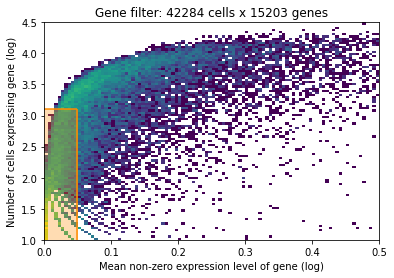

INFO     Using batches from adata.obs["batch_key"]                                           
INFO     Using labels from adata.obs["cell_state"]                                           
INFO     Using data from adata.X                                                             


/lustre/scratch117/cellgen/team205/kk18/miniconda3/envs/cell2loc_env/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function setup_anndata is deprecated; Please use the model-specific setup_anndata methods instead. The global method will be removed in version 0.15.0.


INFO     Successfully registered anndata object containing 42284 cells, 15203 vars, 27       
         batches, 49 labels, and 0 proteins. Also registered 0 extra categorical covariates  
         and 0 extra continuous covariates.                                                  
INFO     Please do not further modify adata until model is trained.                          


/lustre/scratch117/cellgen/team205/kk18/miniconda3/envs/cell2loc_env/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function view_anndata_setup is deprecated; This method will be removed in 0.15.0. Please avoid building any new dependencies on it.


Anndata setup with scvi-tools version 0.14.4.

              Data Summary              
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━┓
┃             Data             ┃ Count ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━┩
│            Cells             │ 42284 │
│             Vars             │ 15203 │
│            Labels            │  49   │
│           Batches            │  27   │
│           Proteins           │   0   │
│ Extra Categorical Covariates │   0   │
│ Extra Continuous Covariates  │   0   │
└──────────────────────────────┴───────┘

             SCVI Data Registry              
┏━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃     Data      ┃    scvi-tools Location    ┃
┡━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       X       │          adata.X          │
│ batch_indices │ adata.obs['_scvi_batch']  │
│    labels     │ adata.obs['_scvi_labels'] │
└───────────────┴───────────────────────────┘

                          Label Categories                          
┏━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃     Source Location     ┃    Categories    ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['cell_state'] │      Adip1       │          0          │
│                         │      Adip2       │          1          │
│                         │        B         │          2          │
│                         │     B_plasma     │          3          │
│                         │     CD14+Mo      │          4          │
│                         │     CD16+Mo      │          5          │
│                         │    CD4+T_act     │          6          │
│                         │   CD4+T_naive    │          7          │
│                         │   CD8+T_cytox    │          8          │
│                         │     CD8+T_em     │          9          │
│                         │     CD8+T_te     │         10          │
│                         │   CD8+T_trans    │         11          │
│                         │        DC        │         12          │
│                         │  EC10_CMC-like   │         13          │
│                         │     EC1_cap      │         14          │
│                         │     EC2_cap      │         15          │
│                         │     EC3_cap      │         16          │
│                         │    EC4_immune    │         17          │
│                         │     EC5_art      │         18          │
│                         │     EC6_ven      │         19          │
│                         │    EC7_atria     │         20          │
│                         │      EC8_ln      │         21          │
│                         │       FB1        │         22          │
│                         │       FB2        │         23          │
│                         │       FB3        │         24          │
│                         │       FB4        │         25          │
│                         │       FB5        │         26          │
│                         │       FB6        │         27          │
│                         │       ILC        │         28          │
│                         │  LYVE1+IGF1+MP   │         29          │
│                         │ LYVE1+MP_cycling │         30          │
│                         │  LYVE1+TIMD4+MP  │         31          │
│                         │    MAIT-like     │         32          │
│                         │       Mast       │         33          │
│                         │       MoMP       │         34          │
│                         │       NC1        │         35          │
│                         │       NC2        │         36          │
│                         │    NK_CD16hi     │         37          │
│                         │    NK_CD56hi     │         38          │
│                         │       Neut       │         39          │
│                         │    PC2_atria     │         40          │
│                         │     PC3_str      │         41          │
│                         │    SAN_P_cell    │         42          │
│                         │    SMC1_basic    │         43          │
│                         │     SMC2_art     │         44          │
│                         │       aCM1       │         45          │
│                         │       aCM2       │         46          │
│                         │       aCM3       │         47          │
│                         │       aCM4       │         48          │
└─────────────────────────┴──────────────────┴─────────────────────┘

                            Batch Categories                             
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃    Source Location     ┃       Categories       ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['batch_key'] │ A61_Nuclei_Multiome-v1 │          0          │
│                        │ AH1_Nuclei_Multiome-v1 │          1          │
│                        │   D11_Cell_3prime-v3   │          2          │
│                        │  D11_Nuclei_3prime-v3  │          3          │
│                        │   D1_Cell_3prime-v2    │          4          │
│                        │  D1_Nuclei_3prime-v2   │          5          │
│                        │  D2_Nuclei_3prime-v2   │          6          │
│                        │   D3_Cell_3prime-v2    │          7          │
│                        │  D3_Nuclei_3prime-v2   │          8          │
│                        │ D3_Nuclei_Multiome-v1  │          9          │
│                        │   D4_Cell_3prime-v2    │         10          │
│                        │  D4_Nuclei_3prime-v2   │         11          │
│                        │   D5_Cell_3prime-v2    │         12          │
│                        │  D5_Nuclei_3prime-v2   │         13          │
│                        │   D6_Cell_3prime-v2    │         14          │
│                        │   D6_Cell_3prime-v3    │         15          │
│                        │  D6_Nuclei_3prime-v2   │         16          │
│                        │   D7_Cell_3prime-v2    │         17          │
│                        │  D7_Nuclei_3prime-v2   │         18          │
│                        │ D7_Nuclei_Multiome-v1  │         19          │
│                        │ D8_Nuclei_Multiome-v1  │         20          │
│                        │  H2_Nuclei_3prime-v3   │         21          │
│                        │  H3_Nuclei_3prime-v3   │         22          │
│                        │  H4_Nuclei_3prime-v3   │         23          │
│                        │  H5_Nuclei_3prime-v3   │         24          │
│                        │  H6_Nuclei_3prime-v3   │         25          │
│                        │  H7_Nuclei_3prime-v3   │         26          │
└────────────────────────┴────────────────────────┴─────────────────────┘

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
/lustre/scratch117/cellgen/team205/kk18/miniconda3/envs/cell2loc_env/lib/python3.9/site-packages/pytorch_lightning/trainer/configuration_validator.py:99: UserWarning: you passed in a val_dataloader but have no validation_step. Skipping val loop
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Sampling global variables, sample: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 999/999 [00:15<00:00, 65.97it/s]


/lustre/scratch117/cellgen/team205/kk18/miniconda3/envs/cell2loc_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
... storing 'sangerID' as categorical
/lustre/scratch117/cellgen/team205/kk18/miniconda3/envs/cell2loc_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
... storing 'combinedID' as categorical
/lustre/scratch117/cellgen/team205/kk18/miniconda3/envs/cell2loc_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version.

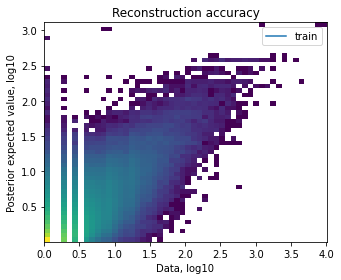

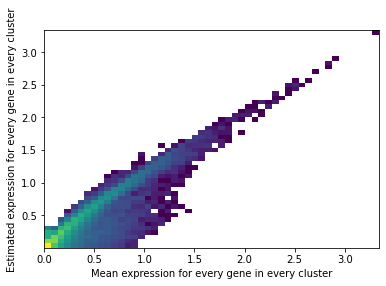

####### AVN #######
                   pre  post_add-subsample
AVN_P_cell          55                  55
AVN_bundle_cell     44                  44
Adip1              135                 135
Adip2               39                1416
B                   23                1082
CD14+Mo             21                2000
CD16+Mo            114                 114
CD4+T_act           40                1758
CD4+T_naive         56                2000
CD8+T_cytox          9                1322
CD8+T_em            24                1375
CD8+T_trans         25                2000
DC                  20                 874
EC10_CMC-like       84                2000
EC1_cap            458                 458
EC2_cap            166                 166
EC3_cap             93                2000
EC4_immune          39                2000
EC5_art            562                 562
EC6_ven            395                 395
EC7_atria           27                2000
EC8_ln              51            

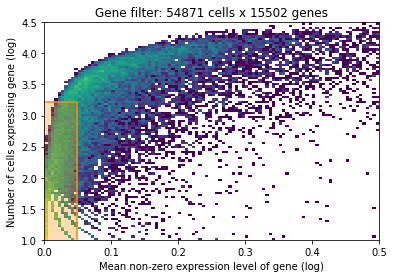

INFO     Using batches from adata.obs["batch_key"]                                           
INFO     Using labels from adata.obs["cell_state"]                                           
INFO     Using data from adata.X                                                             


/lustre/scratch117/cellgen/team205/kk18/miniconda3/envs/cell2loc_env/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function setup_anndata is deprecated; Please use the model-specific setup_anndata methods instead. The global method will be removed in version 0.15.0.


INFO     Successfully registered anndata object containing 54871 cells, 15502 vars, 27       
         batches, 52 labels, and 0 proteins. Also registered 0 extra categorical covariates  
         and 0 extra continuous covariates.                                                  
INFO     Please do not further modify adata until model is trained.                          


/lustre/scratch117/cellgen/team205/kk18/miniconda3/envs/cell2loc_env/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function view_anndata_setup is deprecated; This method will be removed in 0.15.0. Please avoid building any new dependencies on it.


Anndata setup with scvi-tools version 0.14.4.

              Data Summary              
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━┓
┃             Data             ┃ Count ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━┩
│            Cells             │ 54871 │
│             Vars             │ 15502 │
│            Labels            │  52   │
│           Batches            │  27   │
│           Proteins           │   0   │
│ Extra Categorical Covariates │   0   │
│ Extra Continuous Covariates  │   0   │
└──────────────────────────────┴───────┘

             SCVI Data Registry              
┏━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃     Data      ┃    scvi-tools Location    ┃
┡━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       X       │          adata.X          │
│ batch_indices │ adata.obs['_scvi_batch']  │
│    labels     │ adata.obs['_scvi_labels'] │
└───────────────┴───────────────────────────┘

                          Label Categories                          
┏━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃     Source Location     ┃    Categories    ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['cell_state'] │    AVN_P_cell    │          0          │
│                         │ AVN_bundle_cell  │          1          │
│                         │      Adip1       │          2          │
│                         │      Adip2       │          3          │
│                         │        B         │          4          │
│                         │     CD14+Mo      │          5          │
│                         │     CD16+Mo      │          6          │
│                         │    CD4+T_act     │          7          │
│                         │   CD4+T_naive    │          8          │
│                         │   CD8+T_cytox    │          9          │
│                         │     CD8+T_em     │         10          │
│                         │   CD8+T_trans    │         11          │
│                         │        DC        │         12          │
│                         │  EC10_CMC-like   │         13          │
│                         │     EC1_cap      │         14          │
│                         │     EC2_cap      │         15          │
│                         │     EC3_cap      │         16          │
│                         │    EC4_immune    │         17          │
│                         │     EC5_art      │         18          │
│                         │     EC6_ven      │         19          │
│                         │    EC7_atria     │         20          │
│                         │      EC8_ln      │         21          │
│                         │       FB1        │         22          │
│                         │       FB2        │         23          │
│                         │       FB3        │         24          │
│                         │       FB4        │         25          │
│                         │       FB5        │         26          │
│                         │       FB6        │         27          │
│                         │  LYVE1+IGF1+MP   │         28          │
│                         │ LYVE1+MP_cycling │         29          │
│                         │  LYVE1+TIMD4+MP  │         30          │
│                         │    MAIT-like     │         31          │
│                         │       Mast       │         32          │
│                         │       MoMP       │         33          │
│                         │       NC1        │         34          │
│                         │       NC2        │         35          │
│                         │    NK_CD16hi     │         36          │
│                         │    NK_CD56hi     │         37          │
│                         │     PC1_vent     │         38          │
│                         │    PC2_atria     │         39          │
│                         │     PC3_str      │         40          │
│                         │   PC4_CMC-like   │         41          │
│                         │    SMC1_basic    │         42          │
│                         │     SMC2_art     │         43          │
│                         │       aCM1       │         44          │
│                         │       aCM2       │         45          │
│                         │       aCM3       │         46          │
│                         │       aCM4       │         47          │
│                         │       vCM1       │         48          │
│                         │       vCM2       │         49          │
│                         │       vCM3       │         50          │
│                         │       vCM4       │         51          │
└─────────────────────────┴──────────────────┴─────────────────────┘

                            Batch Categories                             
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃    Source Location     ┃       Categories       ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['batch_key'] │ A61_Nuclei_Multiome-v1 │          0          │
│                        │ AH1_Nuclei_Multiome-v1 │          1          │
│                        │   D11_Cell_3prime-v3   │          2          │
│                        │  D11_Nuclei_3prime-v3  │          3          │
│                        │   D1_Cell_3prime-v2    │          4          │
│                        │  D1_Nuclei_3prime-v2   │          5          │
│                        │  D2_Nuclei_3prime-v2   │          6          │
│                        │   D3_Cell_3prime-v2    │          7          │
│                        │  D3_Nuclei_3prime-v2   │          8          │
│                        │ D3_Nuclei_Multiome-v1  │          9          │
│                        │   D4_Cell_3prime-v2    │         10          │
│                        │  D4_Nuclei_3prime-v2   │         11          │
│                        │   D5_Cell_3prime-v2    │         12          │
│                        │  D5_Nuclei_3prime-v2   │         13          │
│                        │   D6_Cell_3prime-v2    │         14          │
│                        │   D6_Cell_3prime-v3    │         15          │
│                        │  D6_Nuclei_3prime-v2   │         16          │
│                        │   D7_Cell_3prime-v2    │         17          │
│                        │  D7_Nuclei_3prime-v2   │         18          │
│                        │ D7_Nuclei_Multiome-v1  │         19          │
│                        │ D8_Nuclei_Multiome-v1  │         20          │
│                        │  H2_Nuclei_3prime-v3   │         21          │
│                        │  H3_Nuclei_3prime-v3   │         22          │
│                        │  H4_Nuclei_3prime-v3   │         23          │
│                        │  H5_Nuclei_3prime-v3   │         24          │
│                        │  H6_Nuclei_3prime-v3   │         25          │
│                        │  H7_Nuclei_3prime-v3   │         26          │
└────────────────────────┴────────────────────────┴─────────────────────┘

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
/lustre/scratch117/cellgen/team205/kk18/miniconda3/envs/cell2loc_env/lib/python3.9/site-packages/pytorch_lightning/trainer/configuration_validator.py:99: UserWarning: you passed in a val_dataloader but have no validation_step. Skipping val loop
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Sampling global variables, sample: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 999/999 [00:13<00:00, 71.61it/s]


/lustre/scratch117/cellgen/team205/kk18/miniconda3/envs/cell2loc_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
... storing 'sangerID' as categorical
/lustre/scratch117/cellgen/team205/kk18/miniconda3/envs/cell2loc_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
... storing 'combinedID' as categorical
/lustre/scratch117/cellgen/team205/kk18/miniconda3/envs/cell2loc_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version.

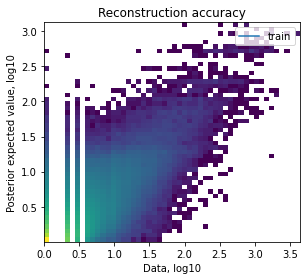

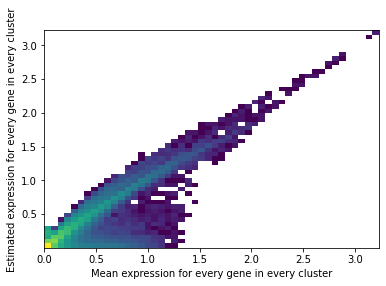

####### RV #######
                    pre  post_add-subsample
Adip1               360                 360
Adip2               158                 158
Adip3                13                 318
B                    41                1082
B_plasma             43                 267
CD14+Mo             304                 304
CD16+Mo             452                 452
CD4+T_Th1             7                  68
CD4+T_Th2            21                 120
CD4+T_act           182                 182
CD4+T_naive         268                 268
CD4+T_reg            10                  67
CD8+T_cytox         194                 194
CD8+T_em            288                 288
CD8+T_te            175                 175
CD8+T_trans         340                 340
DC                  134                 134
EC10_CMC-like       154                 154
EC1_cap            5217                2000
EC2_cap            1855                1855
EC3_cap            2988                2000
EC4_immune   

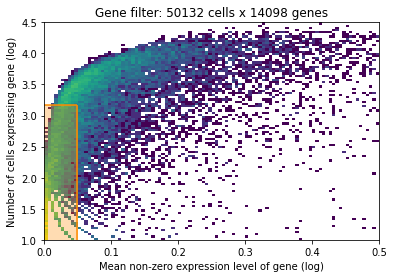

INFO     Using batches from adata.obs["batch_key"]                                           
INFO     Using labels from adata.obs["cell_state"]                                           
INFO     Using data from adata.X                                                             


/lustre/scratch117/cellgen/team205/kk18/miniconda3/envs/cell2loc_env/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function setup_anndata is deprecated; Please use the model-specific setup_anndata methods instead. The global method will be removed in version 0.15.0.


INFO     Successfully registered anndata object containing 50132 cells, 14098 vars, 26       
         batches, 57 labels, and 0 proteins. Also registered 0 extra categorical covariates  
         and 0 extra continuous covariates.                                                  
INFO     Please do not further modify adata until model is trained.                          


/lustre/scratch117/cellgen/team205/kk18/miniconda3/envs/cell2loc_env/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function view_anndata_setup is deprecated; This method will be removed in 0.15.0. Please avoid building any new dependencies on it.


Anndata setup with scvi-tools version 0.14.4.

              Data Summary              
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━┓
┃             Data             ┃ Count ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━┩
│            Cells             │ 50132 │
│             Vars             │ 14098 │
│            Labels            │  57   │
│           Batches            │  26   │
│           Proteins           │   0   │
│ Extra Categorical Covariates │   0   │
│ Extra Continuous Covariates  │   0   │
└──────────────────────────────┴───────┘

             SCVI Data Registry              
┏━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃     Data      ┃    scvi-tools Location    ┃
┡━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       X       │          adata.X          │
│ batch_indices │ adata.obs['_scvi_batch']  │
│    labels     │ adata.obs['_scvi_labels'] │
└───────────────┴───────────────────────────┘

                          Label Categories                          
┏━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃     Source Location     ┃    Categories    ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['cell_state'] │      Adip1       │          0          │
│                         │      Adip2       │          1          │
│                         │      Adip3       │          2          │
│                         │        B         │          3          │
│                         │     B_plasma     │          4          │
│                         │     CD14+Mo      │          5          │
│                         │     CD16+Mo      │          6          │
│                         │    CD4+T_Th1     │          7          │
│                         │    CD4+T_Th2     │          8          │
│                         │    CD4+T_act     │          9          │
│                         │   CD4+T_naive    │         10          │
│                         │    CD4+T_reg     │         11          │
│                         │   CD8+T_cytox    │         12          │
│                         │     CD8+T_em     │         13          │
│                         │     CD8+T_te     │         14          │
│                         │   CD8+T_trans    │         15          │
│                         │        DC        │         16          │
│                         │  EC10_CMC-like   │         17          │
│                         │     EC1_cap      │         18          │
│                         │     EC2_cap      │         19          │
│                         │     EC3_cap      │         20          │
│                         │    EC4_immune    │         21          │
│                         │     EC5_art      │         22          │
│                         │     EC6_ven      │         23          │
│                         │    EC7_atria     │         24          │
│                         │      EC8_ln      │         25          │
│                         │       FB1        │         26          │
│                         │       FB2        │         27          │
│                         │       FB3        │         28          │
│                         │       FB4        │         29          │
│                         │       FB5        │         30          │
│                         │       FB6        │         31          │
│                         │       ILC        │         32          │
│                         │  LYVE1+IGF1+MP   │         33          │
│                         │ LYVE1+MP_cycling │         34          │
│                         │  LYVE1+TIMD4+MP  │         35          │
│                         │    MAIT-like     │         36          │
│                         │       Mast       │         37          │
│                         │       Meso       │         38          │
│                         │       MoMP       │         39          │
│                         │       NC1        │         40          │
│                         │       NC2        │         41          │
│                         │    NK_CD16hi     │         42          │
│                         │    NK_CD56hi     │         43          │
│                         │       Neut       │         44          │
│                         │     PC1_vent     │         45          │
│                         │    PC2_atria     │         46          │
│                         │     PC3_str      │         47          │
│                         │   PC4_CMC-like   │         48          │
│                         │    SMC1_basic    │         49          │
│                         │     SMC2_art     │         50          │
│                         │   T/NK_cycling   │         51          │
│                         │       vCM1       │         52          │
│                         │       vCM2       │         53          

                            Batch Categories                             
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃    Source Location     ┃       Categories       ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['batch_key'] │ A61_Nuclei_Multiome-v1 │          0          │
│                        │ AH1_Nuclei_Multiome-v1 │          1          │
│                        │   D11_Cell_3prime-v3   │          2          │
│                        │  D11_Nuclei_3prime-v3  │          3          │
│                        │  D1_Nuclei_3prime-v2   │          4          │
│                        │  D2_Nuclei_3prime-v2   │          5          │
│                        │   D3_Cell_3prime-v2    │          6          │
│                        │  D3_Nuclei_3prime-v2   │          7          │
│                        │ D3_Nuclei_Multiome-v1  │          8          │
│                        │   D4_Cell_3prime-v2    │          9          │
│                        │  D4_Nuclei_3prime-v2   │         10          │
│                        │   D5_Cell_3prime-v2    │         11          │
│                        │  D5_Nuclei_3prime-v2   │         12          │
│                        │   D6_Cell_3prime-v2    │         13          │
│                        │   D6_Cell_3prime-v3    │         14          │
│                        │  D6_Nuclei_3prime-v2   │         15          │
│                        │   D7_Cell_3prime-v2    │         16          │
│                        │  D7_Nuclei_3prime-v2   │         17          │
│                        │ D7_Nuclei_Multiome-v1  │         18          │
│                        │ D8_Nuclei_Multiome-v1  │         19          │
│                        │  H2_Nuclei_3prime-v3   │         20          │
│                        │  H3_Nuclei_3prime-v3   │         21          │
│                        │  H4_Nuclei_3prime-v3   │         22          │
│                        │  H5_Nuclei_3prime-v3   │         23          │
│                        │  H6_Nuclei_3prime-v3   │         24          │
│                        │  H7_Nuclei_3prime-v3   │         25          │
└────────────────────────┴────────────────────────┴─────────────────────┘

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
/lustre/scratch117/cellgen/team205/kk18/miniconda3/envs/cell2loc_env/lib/python3.9/site-packages/pytorch_lightning/trainer/configuration_validator.py:99: UserWarning: you passed in a val_dataloader but have no validation_step. Skipping val loop
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Sampling global variables, sample: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 999/999 [00:12<00:00, 76.85it/s]


/lustre/scratch117/cellgen/team205/kk18/miniconda3/envs/cell2loc_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
... storing 'sangerID' as categorical
/lustre/scratch117/cellgen/team205/kk18/miniconda3/envs/cell2loc_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
... storing 'combinedID' as categorical
/lustre/scratch117/cellgen/team205/kk18/miniconda3/envs/cell2loc_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version.

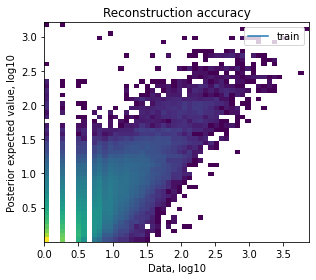

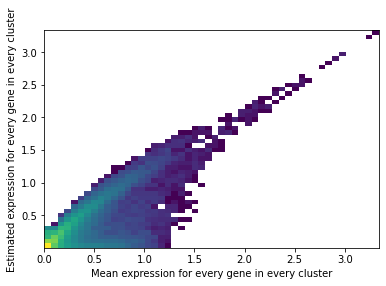

####### LV #######
                    pre  post_add-subsample
Adip1               163                 163
Adip2                28                1416
Adip3                 8                 318
B                   107                 107
B_plasma             21                 267
CD14+Mo             605                 605
CD16+Mo             674                 674
CD4+T_Th1             8                  68
CD4+T_Th2             9                 120
CD4+T_act           172                 172
CD4+T_naive         431                 431
CD4+T_reg             5                  67
CD8+T_cytox         326                 326
CD8+T_em            171                 171
CD8+T_te            171                 171
CD8+T_trans         412                 412
DC                  228                 228
EC10_CMC-like       261                 261
EC1_cap            8526                2000
EC2_cap            4110                2000
EC3_cap            2420                2000
EC4_immune   

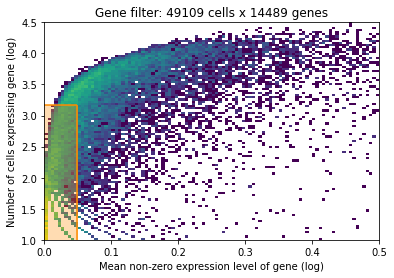

INFO     Using batches from adata.obs["batch_key"]                                           
INFO     Using labels from adata.obs["cell_state"]                                           
INFO     Using data from adata.X                                                             


/lustre/scratch117/cellgen/team205/kk18/miniconda3/envs/cell2loc_env/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function setup_anndata is deprecated; Please use the model-specific setup_anndata methods instead. The global method will be removed in version 0.15.0.


INFO     Successfully registered anndata object containing 49109 cells, 14489 vars, 26       
         batches, 59 labels, and 0 proteins. Also registered 0 extra categorical covariates  
         and 0 extra continuous covariates.                                                  
INFO     Please do not further modify adata until model is trained.                          


/lustre/scratch117/cellgen/team205/kk18/miniconda3/envs/cell2loc_env/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function view_anndata_setup is deprecated; This method will be removed in 0.15.0. Please avoid building any new dependencies on it.


Anndata setup with scvi-tools version 0.14.4.

              Data Summary              
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━┓
┃             Data             ┃ Count ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━┩
│            Cells             │ 49109 │
│             Vars             │ 14489 │
│            Labels            │  59   │
│           Batches            │  26   │
│           Proteins           │   0   │
│ Extra Categorical Covariates │   0   │
│ Extra Continuous Covariates  │   0   │
└──────────────────────────────┴───────┘

             SCVI Data Registry              
┏━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃     Data      ┃    scvi-tools Location    ┃
┡━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       X       │          adata.X          │
│ batch_indices │ adata.obs['_scvi_batch']  │
│    labels     │ adata.obs['_scvi_labels'] │
└───────────────┴───────────────────────────┘

                          Label Categories                          
┏━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃     Source Location     ┃    Categories    ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['cell_state'] │      Adip1       │          0          │
│                         │      Adip2       │          1          │
│                         │      Adip3       │          2          │
│                         │        B         │          3          │
│                         │     B_plasma     │          4          │
│                         │     CD14+Mo      │          5          │
│                         │     CD16+Mo      │          6          │
│                         │    CD4+T_Th1     │          7          │
│                         │    CD4+T_Th2     │          8          │
│                         │    CD4+T_act     │          9          │
│                         │   CD4+T_naive    │         10          │
│                         │    CD4+T_reg     │         11          │
│                         │   CD8+T_cytox    │         12          │
│                         │     CD8+T_em     │         13          │
│                         │     CD8+T_te     │         14          │
│                         │   CD8+T_trans    │         15          │
│                         │        DC        │         16          │
│                         │  EC10_CMC-like   │         17          │
│                         │     EC1_cap      │         18          │
│                         │     EC2_cap      │         19          │
│                         │     EC3_cap      │         20          │
│                         │    EC4_immune    │         21          │
│                         │     EC5_art      │         22          │
│                         │     EC6_ven      │         23          │
│                         │    EC7_atria     │         24          │
│                         │      EC8_ln      │         25          │
│                         │   EC9_FB-like    │         26          │
│                         │       FB1        │         27          │
│                         │       FB2        │         28          │
│                         │       FB3        │         29          │
│                         │       FB4        │         30          │
│                         │       FB5        │         31          │
│                         │       FB6        │         32          │
│                         │       ILC        │         33          │
│                         │  LYVE1+IGF1+MP   │         34          │
│                         │ LYVE1+MP_cycling │         35          │
│                         │  LYVE1+TIMD4+MP  │         36          │
│                         │    MAIT-like     │         37          │
│                         │       Mast       │         38          │
│                         │       Meso       │         39          │
│                         │       MoMP       │         40          │
│                         │       NC1        │         41          │
│                         │       NC2        │         42          │
│                         │    NK_CD16hi     │         43          │
│                         │    NK_CD56hi     │         44          │
│                         │       Neut       │         45          │
│                         │     PC1_vent     │         46          │
│                         │    PC2_atria     │         47          │
│                         │     PC3_str      │         48          │
│                         │   PC4_CMC-like   │         49          │
│                         │    SMC1_basic    │         50          │
│                         │     SMC2_art     │         51          │
│                         │   T/NK_cycling   │         52          │
│                         │       gdT        │         53          

                            Batch Categories                             
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃    Source Location     ┃       Categories       ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['batch_key'] │ A61_Nuclei_Multiome-v1 │          0          │
│                        │ AH1_Nuclei_Multiome-v1 │          1          │
│                        │   D11_Cell_3prime-v3   │          2          │
│                        │  D11_Nuclei_3prime-v3  │          3          │
│                        │  D1_Nuclei_3prime-v2   │          4          │
│                        │  D2_Nuclei_3prime-v2   │          5          │
│                        │   D3_Cell_3prime-v2    │          6          │
│                        │  D3_Nuclei_3prime-v2   │          7          │
│                        │ D3_Nuclei_Multiome-v1  │          8          │
│                        │   D4_Cell_3prime-v2    │          9          │
│                        │  D4_Nuclei_3prime-v2   │         10          │
│                        │   D5_Cell_3prime-v2    │         11          │
│                        │  D5_Nuclei_3prime-v2   │         12          │
│                        │   D6_Cell_3prime-v2    │         13          │
│                        │   D6_Cell_3prime-v3    │         14          │
│                        │  D6_Nuclei_3prime-v2   │         15          │
│                        │   D7_Cell_3prime-v2    │         16          │
│                        │  D7_Nuclei_3prime-v2   │         17          │
│                        │ D7_Nuclei_Multiome-v1  │         18          │
│                        │ D8_Nuclei_Multiome-v1  │         19          │
│                        │  H2_Nuclei_3prime-v3   │         20          │
│                        │  H3_Nuclei_3prime-v3   │         21          │
│                        │  H4_Nuclei_3prime-v3   │         22          │
│                        │  H5_Nuclei_3prime-v3   │         23          │
│                        │  H6_Nuclei_3prime-v3   │         24          │
│                        │  H7_Nuclei_3prime-v3   │         25          │
└────────────────────────┴────────────────────────┴─────────────────────┘

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
/lustre/scratch117/cellgen/team205/kk18/miniconda3/envs/cell2loc_env/lib/python3.9/site-packages/pytorch_lightning/trainer/configuration_validator.py:99: UserWarning: you passed in a val_dataloader but have no validation_step. Skipping val loop
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Sampling global variables, sample: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 999/999 [00:14<00:00, 69.16it/s]


/lustre/scratch117/cellgen/team205/kk18/miniconda3/envs/cell2loc_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
... storing 'sangerID' as categorical
/lustre/scratch117/cellgen/team205/kk18/miniconda3/envs/cell2loc_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
... storing 'combinedID' as categorical
/lustre/scratch117/cellgen/team205/kk18/miniconda3/envs/cell2loc_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version.

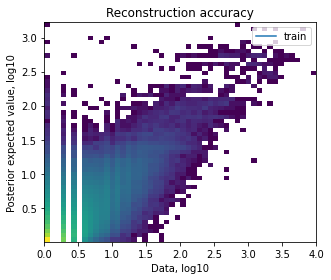

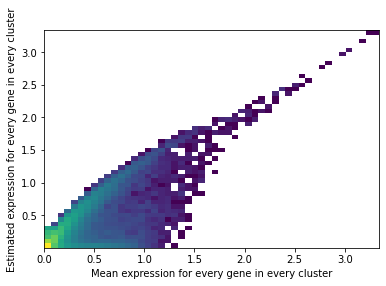

####### SP #######
                    pre  post_add-subsample
Adip1                69                2000
Adip2                17                1416
Adip3                58                 318
B                   103                 103
B_plasma             22                 267
CD14+Mo            1096                1096
CD16+Mo             757                 757
CD4+T_Tfh            14                  79
CD4+T_Th1            15                  68
CD4+T_Th2            19                 120
CD4+T_act           143                 143
CD4+T_naive         330                 330
CD4+T_reg             7                  67
CD8+T_cytox         143                 143
CD8+T_em            150                 150
CD8+T_te            287                 287
CD8+T_trans         199                 199
DC                  112                 112
EC10_CMC-like       189                 189
EC1_cap            6361                2000
EC2_cap            2815                2000
EC3_cap      

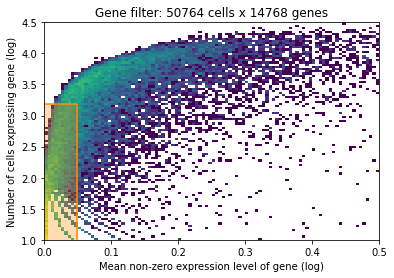

INFO     Using batches from adata.obs["batch_key"]                                           
INFO     Using labels from adata.obs["cell_state"]                                           
INFO     Using data from adata.X                                                             


/lustre/scratch117/cellgen/team205/kk18/miniconda3/envs/cell2loc_env/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function setup_anndata is deprecated; Please use the model-specific setup_anndata methods instead. The global method will be removed in version 0.15.0.


INFO     Successfully registered anndata object containing 50764 cells, 14768 vars, 26       
         batches, 59 labels, and 0 proteins. Also registered 0 extra categorical covariates  
         and 0 extra continuous covariates.                                                  
INFO     Please do not further modify adata until model is trained.                          


/lustre/scratch117/cellgen/team205/kk18/miniconda3/envs/cell2loc_env/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function view_anndata_setup is deprecated; This method will be removed in 0.15.0. Please avoid building any new dependencies on it.


Anndata setup with scvi-tools version 0.14.4.

              Data Summary              
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━┓
┃             Data             ┃ Count ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━┩
│            Cells             │ 50764 │
│             Vars             │ 14768 │
│            Labels            │  59   │
│           Batches            │  26   │
│           Proteins           │   0   │
│ Extra Categorical Covariates │   0   │
│ Extra Continuous Covariates  │   0   │
└──────────────────────────────┴───────┘

             SCVI Data Registry              
┏━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃     Data      ┃    scvi-tools Location    ┃
┡━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       X       │          adata.X          │
│ batch_indices │ adata.obs['_scvi_batch']  │
│    labels     │ adata.obs['_scvi_labels'] │
└───────────────┴───────────────────────────┘

                          Label Categories                          
┏━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃     Source Location     ┃    Categories    ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['cell_state'] │      Adip1       │          0          │
│                         │      Adip2       │          1          │
│                         │      Adip3       │          2          │
│                         │        B         │          3          │
│                         │     B_plasma     │          4          │
│                         │     CD14+Mo      │          5          │
│                         │     CD16+Mo      │          6          │
│                         │    CD4+T_Tfh     │          7          │
│                         │    CD4+T_Th1     │          8          │
│                         │    CD4+T_Th2     │          9          │
│                         │    CD4+T_act     │         10          │
│                         │   CD4+T_naive    │         11          │
│                         │    CD4+T_reg     │         12          │
│                         │   CD8+T_cytox    │         13          │
│                         │     CD8+T_em     │         14          │
│                         │     CD8+T_te     │         15          │
│                         │   CD8+T_trans    │         16          │
│                         │        DC        │         17          │
│                         │  EC10_CMC-like   │         18          │
│                         │     EC1_cap      │         19          │
│                         │     EC2_cap      │         20          │
│                         │     EC3_cap      │         21          │
│                         │    EC4_immune    │         22          │
│                         │     EC5_art      │         23          │
│                         │     EC6_ven      │         24          │
│                         │    EC7_atria     │         25          │
│                         │      EC8_ln      │         26          │
│                         │   EC9_FB-like    │         27          │
│                         │       FB1        │         28          │
│                         │       FB2        │         29          │
│                         │       FB3        │         30          │
│                         │       FB4        │         31          │
│                         │       FB5        │         32          │
│                         │       FB6        │         33          │
│                         │       ILC        │         34          │
│                         │  LYVE1+IGF1+MP   │         35          │
│                         │ LYVE1+MP_cycling │         36          │
│                         │  LYVE1+TIMD4+MP  │         37          │
│                         │    MAIT-like     │         38          │
│                         │       Mast       │         39          │
│                         │       MoMP       │         40          │
│                         │       NC1        │         41          │
│                         │       NC2        │         42          │
│                         │    NK_CD16hi     │         43          │
│                         │    NK_CD56hi     │         44          │
│                         │       Neut       │         45          │
│                         │     PC1_vent     │         46          │
│                         │    PC2_atria     │         47          │
│                         │     PC3_str      │         48          │
│                         │   PC4_CMC-like   │         49          │
│                         │    SMC1_basic    │         50          │
│                         │     SMC2_art     │         51          │
│                         │   T/NK_cycling   │         52          │
│                         │       gdT        │         53          

                            Batch Categories                             
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃    Source Location     ┃       Categories       ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['batch_key'] │ A61_Nuclei_Multiome-v1 │          0          │
│                        │ AH1_Nuclei_Multiome-v1 │          1          │
│                        │   D11_Cell_3prime-v3   │          2          │
│                        │  D11_Nuclei_3prime-v3  │          3          │
│                        │  D1_Nuclei_3prime-v2   │          4          │
│                        │  D2_Nuclei_3prime-v2   │          5          │
│                        │   D3_Cell_3prime-v2    │          6          │
│                        │  D3_Nuclei_3prime-v2   │          7          │
│                        │ D3_Nuclei_Multiome-v1  │          8          │
│                        │   D4_Cell_3prime-v2    │          9          │
│                        │  D4_Nuclei_3prime-v2   │         10          │
│                        │   D5_Cell_3prime-v2    │         11          │
│                        │  D5_Nuclei_3prime-v2   │         12          │
│                        │   D6_Cell_3prime-v2    │         13          │
│                        │   D6_Cell_3prime-v3    │         14          │
│                        │  D6_Nuclei_3prime-v2   │         15          │
│                        │   D7_Cell_3prime-v2    │         16          │
│                        │  D7_Nuclei_3prime-v2   │         17          │
│                        │ D7_Nuclei_Multiome-v1  │         18          │
│                        │ D8_Nuclei_Multiome-v1  │         19          │
│                        │  H2_Nuclei_3prime-v3   │         20          │
│                        │  H3_Nuclei_3prime-v3   │         21          │
│                        │  H4_Nuclei_3prime-v3   │         22          │
│                        │  H5_Nuclei_3prime-v3   │         23          │
│                        │  H6_Nuclei_3prime-v3   │         24          │
│                        │  H7_Nuclei_3prime-v3   │         25          │
└────────────────────────┴────────────────────────┴─────────────────────┘

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
/lustre/scratch117/cellgen/team205/kk18/miniconda3/envs/cell2loc_env/lib/python3.9/site-packages/pytorch_lightning/trainer/configuration_validator.py:99: UserWarning: you passed in a val_dataloader but have no validation_step. Skipping val loop
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Sampling global variables, sample: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 999/999 [00:12<00:00, 77.93it/s]


/lustre/scratch117/cellgen/team205/kk18/miniconda3/envs/cell2loc_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
... storing 'sangerID' as categorical
/lustre/scratch117/cellgen/team205/kk18/miniconda3/envs/cell2loc_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
... storing 'combinedID' as categorical
/lustre/scratch117/cellgen/team205/kk18/miniconda3/envs/cell2loc_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version.

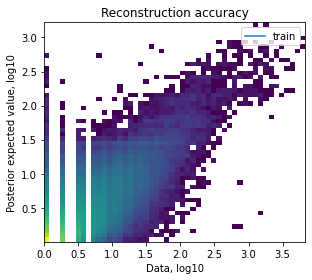

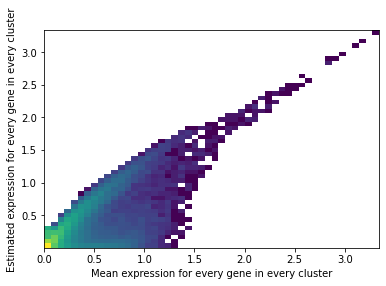

####### AX #######
                    pre  post_add-subsample
Adip1               617                 617
Adip2               147                 147
Adip3                67                 318
Adip4                40                  63
B                   115                 115
B_plasma             15                 267
CD14+Mo             492                 492
CD16+Mo             531                 531
CD4+T_Tfh            25                  79
CD4+T_Th1             9                  68
CD4+T_Th2            20                 120
CD4+T_act           234                 234
CD4+T_naive         342                 342
CD4+T_reg            11                  67
CD8+T_cytox         257                 257
CD8+T_em            177                 177
CD8+T_te            352                 352
CD8+T_trans         262                 262
DC                  135                 135
EC10_CMC-like       222                 222
EC1_cap            8211                2000
EC2_cap      

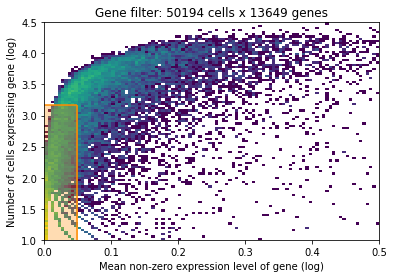

INFO     Using batches from adata.obs["batch_key"]                                           
INFO     Using labels from adata.obs["cell_state"]                                           
INFO     Using data from adata.X                                                             


/lustre/scratch117/cellgen/team205/kk18/miniconda3/envs/cell2loc_env/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function setup_anndata is deprecated; Please use the model-specific setup_anndata methods instead. The global method will be removed in version 0.15.0.
/lustre/scratch117/cellgen/team205/kk18/miniconda3/envs/cell2loc_env/lib/python3.9/site-packages/scvi/data/_anndata.py:743: UserWarning: Category 9 in adata.obs['_scvi_batch'] has fewer than 3 cells. SCVI may not train properly.


INFO     Successfully registered anndata object containing 50194 cells, 13649 vars, 27       
         batches, 60 labels, and 0 proteins. Also registered 0 extra categorical covariates  
         and 0 extra continuous covariates.                                                  
INFO     Please do not further modify adata until model is trained.                          


/lustre/scratch117/cellgen/team205/kk18/miniconda3/envs/cell2loc_env/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function view_anndata_setup is deprecated; This method will be removed in 0.15.0. Please avoid building any new dependencies on it.


Anndata setup with scvi-tools version 0.14.4.

              Data Summary              
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━┓
┃             Data             ┃ Count ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━┩
│            Cells             │ 50194 │
│             Vars             │ 13649 │
│            Labels            │  60   │
│           Batches            │  27   │
│           Proteins           │   0   │
│ Extra Categorical Covariates │   0   │
│ Extra Continuous Covariates  │   0   │
└──────────────────────────────┴───────┘

             SCVI Data Registry              
┏━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃     Data      ┃    scvi-tools Location    ┃
┡━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       X       │          adata.X          │
│ batch_indices │ adata.obs['_scvi_batch']  │
│    labels     │ adata.obs['_scvi_labels'] │
└───────────────┴───────────────────────────┘

                          Label Categories                          
┏━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃     Source Location     ┃    Categories    ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['cell_state'] │      Adip1       │          0          │
│                         │      Adip2       │          1          │
│                         │      Adip3       │          2          │
│                         │      Adip4       │          3          │
│                         │        B         │          4          │
│                         │     B_plasma     │          5          │
│                         │     CD14+Mo      │          6          │
│                         │     CD16+Mo      │          7          │
│                         │    CD4+T_Tfh     │          8          │
│                         │    CD4+T_Th1     │          9          │
│                         │    CD4+T_Th2     │         10          │
│                         │    CD4+T_act     │         11          │
│                         │   CD4+T_naive    │         12          │
│                         │    CD4+T_reg     │         13          │
│                         │   CD8+T_cytox    │         14          │
│                         │     CD8+T_em     │         15          │
│                         │     CD8+T_te     │         16          │
│                         │   CD8+T_trans    │         17          │
│                         │        DC        │         18          │
│                         │  EC10_CMC-like   │         19          │
│                         │     EC1_cap      │         20          │
│                         │     EC2_cap      │         21          │
│                         │     EC3_cap      │         22          │
│                         │    EC4_immune    │         23          │
│                         │     EC5_art      │         24          │
│                         │     EC6_ven      │         25          │
│                         │    EC7_atria     │         26          │
│                         │      EC8_ln      │         27          │
│                         │   EC9_FB-like    │         28          │
│                         │       FB1        │         29          │
│                         │       FB2        │         30          │
│                         │       FB3        │         31          │
│                         │       FB4        │         32          │
│                         │       FB5        │         33          │
│                         │       FB6        │         34          │
│                         │       ILC        │         35          │
│                         │  LYVE1+IGF1+MP   │         36          │
│                         │ LYVE1+MP_cycling │         37          │
│                         │  LYVE1+TIMD4+MP  │         38          │
│                         │    MAIT-like     │         39          │
│                         │       Mast       │         40          │
│                         │       Meso       │         41          │
│                         │       MoMP       │         42          │
│                         │       NC1        │         43          │
│                         │       NC2        │         44          │
│                         │    NK_CD16hi     │         45          │
│                         │    NK_CD56hi     │         46          │
│                         │       Neut       │         47          │
│                         │     PC1_vent     │         48          │
│                         │    PC2_atria     │         49          │
│                         │     PC3_str      │         50          │
│                         │   PC4_CMC-like   │         51          │
│                         │    SMC1_basic    │         52          │
│                         │     SMC2_art     │         53          

                            Batch Categories                             
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃    Source Location     ┃       Categories       ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['batch_key'] │ A61_Nuclei_Multiome-v1 │          0          │
│                        │ AH1_Nuclei_Multiome-v1 │          1          │
│                        │   D11_Cell_3prime-v3   │          2          │
│                        │  D11_Nuclei_3prime-v3  │          3          │
│                        │   D1_Cell_3prime-v2    │          4          │
│                        │  D1_Nuclei_3prime-v2   │          5          │
│                        │  D2_Nuclei_3prime-v2   │          6          │
│                        │   D3_Cell_3prime-v2    │          7          │
│                        │  D3_Nuclei_3prime-v2   │          8          │
│                        │ D3_Nuclei_Multiome-v1  │          9          │
│                        │   D4_Cell_3prime-v2    │         10          │
│                        │  D4_Nuclei_3prime-v2   │         11          │
│                        │   D5_Cell_3prime-v2    │         12          │
│                        │  D5_Nuclei_3prime-v2   │         13          │
│                        │   D6_Cell_3prime-v2    │         14          │
│                        │   D6_Cell_3prime-v3    │         15          │
│                        │  D6_Nuclei_3prime-v2   │         16          │
│                        │   D7_Cell_3prime-v2    │         17          │
│                        │  D7_Nuclei_3prime-v2   │         18          │
│                        │ D7_Nuclei_Multiome-v1  │         19          │
│                        │ D8_Nuclei_Multiome-v1  │         20          │
│                        │  H2_Nuclei_3prime-v3   │         21          │
│                        │  H3_Nuclei_3prime-v3   │         22          │
│                        │  H4_Nuclei_3prime-v3   │         23          │
│                        │  H5_Nuclei_3prime-v3   │         24          │
│                        │  H6_Nuclei_3prime-v3   │         25          │
│                        │  H7_Nuclei_3prime-v3   │         26          │
└────────────────────────┴────────────────────────┴─────────────────────┘

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
/lustre/scratch117/cellgen/team205/kk18/miniconda3/envs/cell2loc_env/lib/python3.9/site-packages/pytorch_lightning/trainer/configuration_validator.py:99: UserWarning: you passed in a val_dataloader but have no validation_step. Skipping val loop
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Sampling global variables, sample: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 999/999 [00:12<00:00, 78.87it/s]


/lustre/scratch117/cellgen/team205/kk18/miniconda3/envs/cell2loc_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
... storing 'sangerID' as categorical
/lustre/scratch117/cellgen/team205/kk18/miniconda3/envs/cell2loc_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
... storing 'combinedID' as categorical
/lustre/scratch117/cellgen/team205/kk18/miniconda3/envs/cell2loc_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version.

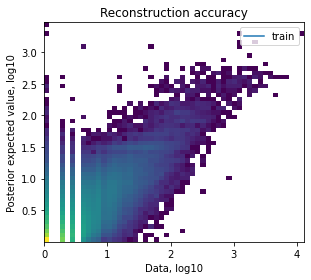

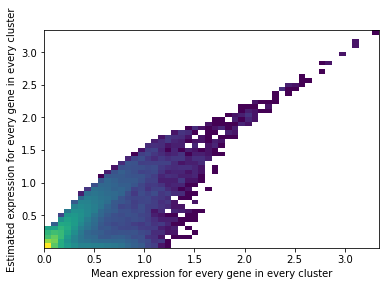

####### RA #######
                    pre  post_add-subsample
Adip1               405                 405
Adip2               247                 247
Adip3                93                 318
B                   445                 445
B_plasma            117                 117
CD14+Mo             387                 387
CD16+Mo             551                 551
CD4+T_Tfh             9                  79
CD4+T_Th1             8                  68
CD4+T_Th2            19                 120
CD4+T_act           362                 362
CD4+T_naive         350                 350
CD4+T_reg            16                  67
CD8+T_cytox         194                 194
CD8+T_em            192                 192
CD8+T_te            609                 609
CD8+T_trans         328                 328
DC                   79                 874
EC10_CMC-like      1069                1069
EC1_cap             836                 836
EC2_cap             174                 174
EC3_cap      

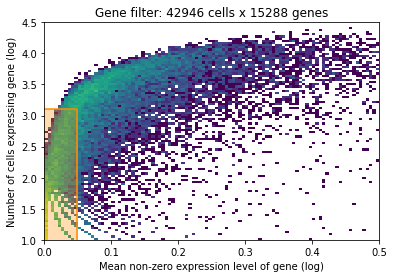

INFO     Using batches from adata.obs["batch_key"]                                           
INFO     Using labels from adata.obs["cell_state"]                                           
INFO     Using data from adata.X                                                             


/lustre/scratch117/cellgen/team205/kk18/miniconda3/envs/cell2loc_env/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function setup_anndata is deprecated; Please use the model-specific setup_anndata methods instead. The global method will be removed in version 0.15.0.


INFO     Successfully registered anndata object containing 42946 cells, 15288 vars, 26       
         batches, 59 labels, and 0 proteins. Also registered 0 extra categorical covariates  
         and 0 extra continuous covariates.                                                  
INFO     Please do not further modify adata until model is trained.                          


/lustre/scratch117/cellgen/team205/kk18/miniconda3/envs/cell2loc_env/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function view_anndata_setup is deprecated; This method will be removed in 0.15.0. Please avoid building any new dependencies on it.


Anndata setup with scvi-tools version 0.14.4.

              Data Summary              
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━┓
┃             Data             ┃ Count ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━┩
│            Cells             │ 42946 │
│             Vars             │ 15288 │
│            Labels            │  59   │
│           Batches            │  26   │
│           Proteins           │   0   │
│ Extra Categorical Covariates │   0   │
│ Extra Continuous Covariates  │   0   │
└──────────────────────────────┴───────┘

             SCVI Data Registry              
┏━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃     Data      ┃    scvi-tools Location    ┃
┡━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       X       │          adata.X          │
│ batch_indices │ adata.obs['_scvi_batch']  │
│    labels     │ adata.obs['_scvi_labels'] │
└───────────────┴───────────────────────────┘

                          Label Categories                          
┏━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃     Source Location     ┃    Categories    ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['cell_state'] │      Adip1       │          0          │
│                         │      Adip2       │          1          │
│                         │      Adip3       │          2          │
│                         │        B         │          3          │
│                         │     B_plasma     │          4          │
│                         │     CD14+Mo      │          5          │
│                         │     CD16+Mo      │          6          │
│                         │    CD4+T_Tfh     │          7          │
│                         │    CD4+T_Th1     │          8          │
│                         │    CD4+T_Th2     │          9          │
│                         │    CD4+T_act     │         10          │
│                         │   CD4+T_naive    │         11          │
│                         │    CD4+T_reg     │         12          │
│                         │   CD8+T_cytox    │         13          │
│                         │     CD8+T_em     │         14          │
│                         │     CD8+T_te     │         15          │
│                         │   CD8+T_trans    │         16          │
│                         │        DC        │         17          │
│                         │  EC10_CMC-like   │         18          │
│                         │     EC1_cap      │         19          │
│                         │     EC2_cap      │         20          │
│                         │     EC3_cap      │         21          │
│                         │    EC4_immune    │         22          │
│                         │     EC5_art      │         23          │
│                         │     EC6_ven      │         24          │
│                         │    EC7_atria     │         25          │
│                         │      EC8_ln      │         26          │
│                         │       FB1        │         27          │
│                         │       FB2        │         28          │
│                         │       FB3        │         29          │
│                         │       FB4        │         30          │
│                         │       FB5        │         31          │
│                         │       FB6        │         32          │
│                         │       ILC        │         33          │
│                         │  LYVE1+IGF1+MP   │         34          │
│                         │ LYVE1+MP_cycling │         35          │
│                         │  LYVE1+TIMD4+MP  │         36          │
│                         │    MAIT-like     │         37          │
│                         │       Mast       │         38          │
│                         │       Meso       │         39          │
│                         │       MoMP       │         40          │
│                         │       NC1        │         41          │
│                         │       NC2        │         42          │
│                         │       NC5        │         43          │
│                         │    NK_CD16hi     │         44          │
│                         │    NK_CD56hi     │         45          │
│                         │       Neut       │         46          │
│                         │     PC1_vent     │         47          │
│                         │    PC2_atria     │         48          │
│                         │     PC3_str      │         49          │
│                         │   PC4_CMC-like   │         50          │
│                         │    SMC1_basic    │         51          │
│                         │     SMC2_art     │         52          │
│                         │   T/NK_cycling   │         53          

                            Batch Categories                             
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃    Source Location     ┃       Categories       ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['batch_key'] │ A61_Nuclei_Multiome-v1 │          0          │
│                        │ AH1_Nuclei_Multiome-v1 │          1          │
│                        │   D11_Cell_3prime-v3   │          2          │
│                        │  D11_Nuclei_3prime-v3  │          3          │
│                        │  D1_Nuclei_3prime-v2   │          4          │
│                        │  D2_Nuclei_3prime-v2   │          5          │
│                        │   D3_Cell_3prime-v2    │          6          │
│                        │  D3_Nuclei_3prime-v2   │          7          │
│                        │ D3_Nuclei_Multiome-v1  │          8          │
│                        │   D4_Cell_3prime-v2    │          9          │
│                        │  D4_Nuclei_3prime-v2   │         10          │
│                        │   D5_Cell_3prime-v2    │         11          │
│                        │  D5_Nuclei_3prime-v2   │         12          │
│                        │   D6_Cell_3prime-v2    │         13          │
│                        │   D6_Cell_3prime-v3    │         14          │
│                        │  D6_Nuclei_3prime-v2   │         15          │
│                        │   D7_Cell_3prime-v2    │         16          │
│                        │  D7_Nuclei_3prime-v2   │         17          │
│                        │ D7_Nuclei_Multiome-v1  │         18          │
│                        │ D8_Nuclei_Multiome-v1  │         19          │
│                        │  H2_Nuclei_3prime-v3   │         20          │
│                        │  H3_Nuclei_3prime-v3   │         21          │
│                        │  H4_Nuclei_3prime-v3   │         22          │
│                        │  H5_Nuclei_3prime-v3   │         23          │
│                        │  H6_Nuclei_3prime-v3   │         24          │
│                        │  H7_Nuclei_3prime-v3   │         25          │
└────────────────────────┴────────────────────────┴─────────────────────┘

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
/lustre/scratch117/cellgen/team205/kk18/miniconda3/envs/cell2loc_env/lib/python3.9/site-packages/pytorch_lightning/trainer/configuration_validator.py:99: UserWarning: you passed in a val_dataloader but have no validation_step. Skipping val loop
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 635/1000:  63%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                | 634/1000 [27:20<15:47,  2.59s/it, v_num=1, elbo_train=1.95e+8]

/lustre/scratch117/cellgen/team205/kk18/miniconda3/envs/cell2loc_env/lib/python3.9/site-packages/pytorch_lightning/trainer/trainer.py:897: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...


Sampling global variables, sample: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 999/999 [00:15<00:00, 66.40it/s]


/lustre/scratch117/cellgen/team205/kk18/miniconda3/envs/cell2loc_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
... storing 'sangerID' as categorical
/lustre/scratch117/cellgen/team205/kk18/miniconda3/envs/cell2loc_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
... storing 'combinedID' as categorical
/lustre/scratch117/cellgen/team205/kk18/miniconda3/envs/cell2loc_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version.

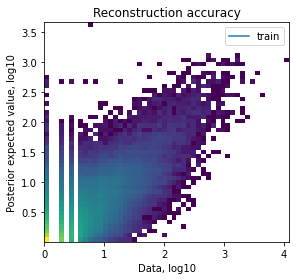

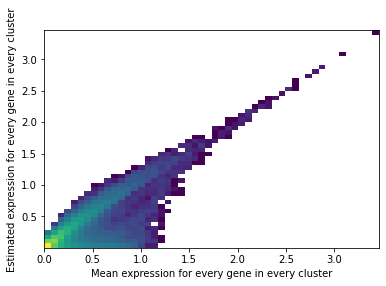

####### LA #######
                    pre  post_add-subsample
Adip1               966                 966
Adip2               577                 577
Adip3                74                 318
Adip4                15                  63
B                   122                 122
B_plasma             39                 267
CD14+Mo             573                 573
CD16+Mo             450                 450
CD4+T_Tfh            25                  79
CD4+T_Th1            21                  68
CD4+T_Th2            32                 120
CD4+T_act           329                 329
CD4+T_naive         456                 456
CD4+T_reg            18                  67
CD8+T_cytox         180                 180
CD8+T_em            206                 206
CD8+T_te            631                 631
CD8+T_trans         275                 275
DC                  109                 109
EC10_CMC-like      1406                1406
EC1_cap            2016                2000
EC2_cap      

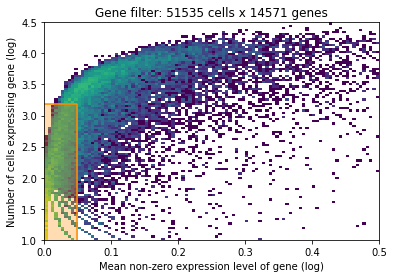

INFO     Using batches from adata.obs["batch_key"]                                           
INFO     Using labels from adata.obs["cell_state"]                                           
INFO     Using data from adata.X                                                             


/lustre/scratch117/cellgen/team205/kk18/miniconda3/envs/cell2loc_env/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function setup_anndata is deprecated; Please use the model-specific setup_anndata methods instead. The global method will be removed in version 0.15.0.


INFO     Successfully registered anndata object containing 51535 cells, 14571 vars, 25       
         batches, 62 labels, and 0 proteins. Also registered 0 extra categorical covariates  
         and 0 extra continuous covariates.                                                  
INFO     Please do not further modify adata until model is trained.                          


/lustre/scratch117/cellgen/team205/kk18/miniconda3/envs/cell2loc_env/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function view_anndata_setup is deprecated; This method will be removed in 0.15.0. Please avoid building any new dependencies on it.


Anndata setup with scvi-tools version 0.14.4.

              Data Summary              
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━┓
┃             Data             ┃ Count ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━┩
│            Cells             │ 51535 │
│             Vars             │ 14571 │
│            Labels            │  62   │
│           Batches            │  25   │
│           Proteins           │   0   │
│ Extra Categorical Covariates │   0   │
│ Extra Continuous Covariates  │   0   │
└──────────────────────────────┴───────┘

             SCVI Data Registry              
┏━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃     Data      ┃    scvi-tools Location    ┃
┡━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       X       │          adata.X          │
│ batch_indices │ adata.obs['_scvi_batch']  │
│    labels     │ adata.obs['_scvi_labels'] │
└───────────────┴───────────────────────────┘

                          Label Categories                          
┏━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃     Source Location     ┃    Categories    ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['cell_state'] │      Adip1       │          0          │
│                         │      Adip2       │          1          │
│                         │      Adip3       │          2          │
│                         │      Adip4       │          3          │
│                         │        B         │          4          │
│                         │     B_plasma     │          5          │
│                         │     CD14+Mo      │          6          │
│                         │     CD16+Mo      │          7          │
│                         │    CD4+T_Tfh     │          8          │
│                         │    CD4+T_Th1     │          9          │
│                         │    CD4+T_Th2     │         10          │
│                         │    CD4+T_act     │         11          │
│                         │   CD4+T_naive    │         12          │
│                         │    CD4+T_reg     │         13          │
│                         │   CD8+T_cytox    │         14          │
│                         │     CD8+T_em     │         15          │
│                         │     CD8+T_te     │         16          │
│                         │   CD8+T_trans    │         17          │
│                         │        DC        │         18          │
│                         │  EC10_CMC-like   │         19          │
│                         │     EC1_cap      │         20          │
│                         │     EC2_cap      │         21          │
│                         │     EC3_cap      │         22          │
│                         │    EC4_immune    │         23          │
│                         │     EC5_art      │         24          │
│                         │     EC6_ven      │         25          │
│                         │    EC7_atria     │         26          │
│                         │      EC8_ln      │         27          │
│                         │       FB1        │         28          │
│                         │       FB2        │         29          │
│                         │       FB3        │         30          │
│                         │       FB4        │         31          │
│                         │       FB5        │         32          │
│                         │       FB6        │         33          │
│                         │       ILC        │         34          │
│                         │  LYVE1+IGF1+MP   │         35          │
│                         │ LYVE1+MP_cycling │         36          │
│                         │  LYVE1+TIMD4+MP  │         37          │
│                         │    MAIT-like     │         38          │
│                         │       Mast       │         39          │
│                         │       Meso       │         40          │
│                         │       MoMP       │         41          │
│                         │       NC1        │         42          │
│                         │       NC2        │         43          │
│                         │       NC3        │         44          │
│                         │       NC5        │         45          │
│                         │       NC6        │         46          │
│                         │    NK_CD16hi     │         47          │
│                         │    NK_CD56hi     │         48          │
│                         │       Neut       │         49          │
│                         │     PC1_vent     │         50          │
│                         │    PC2_atria     │         51          │
│                         │     PC3_str      │         52          │
│                         │   PC4_CMC-like   │         53          

                            Batch Categories                             
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃    Source Location     ┃       Categories       ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['batch_key'] │ A61_Nuclei_Multiome-v1 │          0          │
│                        │ AH1_Nuclei_Multiome-v1 │          1          │
│                        │   D11_Cell_3prime-v3   │          2          │
│                        │  D11_Nuclei_3prime-v3  │          3          │
│                        │  D1_Nuclei_3prime-v2   │          4          │
│                        │  D2_Nuclei_3prime-v2   │          5          │
│                        │   D3_Cell_3prime-v2    │          6          │
│                        │  D3_Nuclei_3prime-v2   │          7          │
│                        │   D4_Cell_3prime-v2    │          8          │
│                        │  D4_Nuclei_3prime-v2   │          9          │
│                        │   D5_Cell_3prime-v2    │         10          │
│                        │  D5_Nuclei_3prime-v2   │         11          │
│                        │   D6_Cell_3prime-v2    │         12          │
│                        │   D6_Cell_3prime-v3    │         13          │
│                        │  D6_Nuclei_3prime-v2   │         14          │
│                        │   D7_Cell_3prime-v2    │         15          │
│                        │  D7_Nuclei_3prime-v2   │         16          │
│                        │ D7_Nuclei_Multiome-v1  │         17          │
│                        │ D8_Nuclei_Multiome-v1  │         18          │
│                        │  H2_Nuclei_3prime-v3   │         19          │
│                        │  H3_Nuclei_3prime-v3   │         20          │
│                        │  H4_Nuclei_3prime-v3   │         21          │
│                        │  H5_Nuclei_3prime-v3   │         22          │
│                        │  H6_Nuclei_3prime-v3   │         23          │
│                        │  H7_Nuclei_3prime-v3   │         24          │
└────────────────────────┴────────────────────────┴─────────────────────┘

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
/lustre/scratch117/cellgen/team205/kk18/miniconda3/envs/cell2loc_env/lib/python3.9/site-packages/pytorch_lightning/trainer/configuration_validator.py:99: UserWarning: you passed in a val_dataloader but have no validation_step. Skipping val loop
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 18/1000:   2%|███                                                                                                                                                                                | 17/1000 [00:51<49:48,  3.04s/it, v_num=1, elbo_train=2.41e+8]

In [ ]:
%%time

from cell2location.utils.filtering import filter_genes
from cell2location.models import RegressionModel

for reg in regions:
    print(f'####### {reg} #######')
    
    # subset adata
    adata_sub = adata_ref[adata_ref.obs['region']==reg].copy()
    
    # remove cell_states, which have less than 5 cells
    counts = adata_sub.obs[celltype_key].value_counts()
    adata_sub = adata_sub[adata_sub.obs[celltype_key].isin(list(counts.keys()[counts>=5]))]
    
    # add cells from other regions for low number (lower than 100) cell types
    counts = adata_sub.obs[celltype_key].value_counts()
    low_n_celltypes = list(counts.keys()[counts<100])
    ## add data of "other" regions & low_n_celltypes
    adata_toadd = adata_ref[(adata_ref.obs['region']!=reg)&(adata_ref.obs['cell_state'].isin(low_n_celltypes))]
    adata_sub = adata_sub.concatenate(adata_toadd,
                                     batch_key=None,
                                      index_unique=None)
    post_counts = adata_sub.obs[celltype_key].value_counts()
    
    # remove cell_states, which have only 2 cells or less
    # adata_sub = adata_sub[adata_sub.obs[celltype_key].isin(list(counts.keys()[post_counts>2]))]
    
    # downsize
    adata_sub = sctk.subsample(adata_sub, fraction=1, groupby=celltype_key, min_n=0, max_n=2000)
    
    # show pre add-sabsample and post
    post_counts = adata_sub.obs[celltype_key].value_counts()
    print(pd.DataFrame({'pre':counts,
                 'post_add-subsample':post_counts}))
    
    # before we estimate the reference cell type signature we recommend to perform very permissive genes selection
    # in this 2D histogram orange rectangle lays over excluded genes.
    # In this case, the downloaded dataset was already filtered using this method,
    # hence no density under the orange rectangle
    selected = filter_genes(adata_sub, cell_count_cutoff=5, cell_percentage_cutoff2=0.03, nonz_mean_cutoff=1.12)
    # filter the object
    adata_sub = adata_sub[:, selected].copy()
    
    # prepare anndata for the regression model
    adata_sub=adata_sub.copy()
    scvi.data.setup_anndata(adata=adata_sub, 
                            # 10X reaction / sample / batch
                            batch_key='batch_key', 
                            # cell type, covariate used for constructing signatures
                            labels_key=celltype_key, 
                            # multiplicative technical effects (platform, 3' vs 5', donor effect)
                            # categorical_covariate_keys=['Method']
                           )
    scvi.data.view_anndata_setup(adata_sub)
    
    # create and train the regression model
    mod = RegressionModel(adata_sub) 

    # Use all data for training (validation not implemented yet, train_size=1)
    mod.train(max_epochs=1000, batch_size=2500, train_size=1, lr=0.002, use_gpu=True)

    # plot ELBO loss history during training, removing first 20 epochs from the plot
    mod.plot_history(20)
    
    # In this section, we export the estimated cell abundance (summary of the posterior distribution).
    adata_sub = mod.export_posterior(
        adata_sub, sample_kwargs={'num_samples': 1000, 'batch_size': 2500, 'use_gpu': True}
    )

    # Save model
    mod.save(f"{ref_run_name}/{reg}", overwrite=True)

    # Save anndata object with results
    # adata_file = f"{ref_run_name}/{reg}/sc.h5ad"
    adata_sub.write(f"{ref_run_name}/{reg}/sc.h5ad")
    
    mod.plot_QC()
    
    # export estimated expression in each cluster
    if 'means_per_cluster_mu_fg' in adata_sub.varm.keys():
        inf_aver = adata_sub.varm['means_per_cluster_mu_fg'][[f'means_per_cluster_mu_fg_{i}' 
                                        for i in adata_sub.uns['mod']['factor_names']]].copy()
    else:
        inf_aver = adata_sub.var[[f'means_per_cluster_mu_fg_{i}' 
                                        for i in adata_sub.uns['mod']['factor_names']]].copy()
    inf_aver.columns = adata_sub.uns['mod']['factor_names']
    inf_aver.iloc[0:5, 0:5]
    
    # save inf_aver
    inf_aver.to_csv(f"{ref_run_name}/{reg}/inf_aver.csv")
                    
    del adata_sub, mod, inf_aver, adata_toadd, counts, post_counts

####### LA #######
                    pre  post_add-subsample
Adip1               966                 966
Adip2               577                 577
Adip3                74                 318
Adip4                15                  63
B                   122                 122
B_plasma             39                 267
CD14+Mo             573                 573
CD16+Mo             450                 450
CD4+T_Tfh            25                  79
CD4+T_Th1            21                  68
CD4+T_Th2            32                 120
CD4+T_act           329                 329
CD4+T_naive         456                 456
CD4+T_reg            18                  67
CD8+T_cytox         180                 180
CD8+T_em            206                 206
CD8+T_te            631                 631
CD8+T_trans         275                 275
DC                  109                 109
EC10_CMC-like      1406                1406
EC1_cap            2016                2000
EC2_cap      

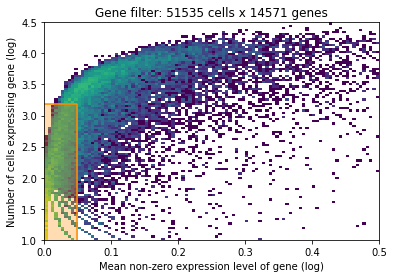

INFO     Using batches from adata.obs["batch_key"]                                           
INFO     Using labels from adata.obs["cell_state"]                                           
INFO     Using data from adata.X                                                             


/lustre/scratch117/cellgen/team205/kk18/miniconda3/envs/cell2loc_env/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function setup_anndata is deprecated; Please use the model-specific setup_anndata methods instead. The global method will be removed in version 0.15.0.


INFO     Successfully registered anndata object containing 51535 cells, 14571 vars, 25       
         batches, 62 labels, and 0 proteins. Also registered 0 extra categorical covariates  
         and 0 extra continuous covariates.                                                  
INFO     Please do not further modify adata until model is trained.                          


/lustre/scratch117/cellgen/team205/kk18/miniconda3/envs/cell2loc_env/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function view_anndata_setup is deprecated; This method will be removed in 0.15.0. Please avoid building any new dependencies on it.


Anndata setup with scvi-tools version 0.14.4.

              Data Summary              
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━┓
┃             Data             ┃ Count ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━┩
│            Cells             │ 51535 │
│             Vars             │ 14571 │
│            Labels            │  62   │
│           Batches            │  25   │
│           Proteins           │   0   │
│ Extra Categorical Covariates │   0   │
│ Extra Continuous Covariates  │   0   │
└──────────────────────────────┴───────┘

             SCVI Data Registry              
┏━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃     Data      ┃    scvi-tools Location    ┃
┡━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       X       │          adata.X          │
│ batch_indices │ adata.obs['_scvi_batch']  │
│    labels     │ adata.obs['_scvi_labels'] │
└───────────────┴───────────────────────────┘

                          Label Categories                          
┏━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃     Source Location     ┃    Categories    ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['cell_state'] │      Adip1       │          0          │
│                         │      Adip2       │          1          │
│                         │      Adip3       │          2          │
│                         │      Adip4       │          3          │
│                         │        B         │          4          │
│                         │     B_plasma     │          5          │
│                         │     CD14+Mo      │          6          │
│                         │     CD16+Mo      │          7          │
│                         │    CD4+T_Tfh     │          8          │
│                         │    CD4+T_Th1     │          9          │
│                         │    CD4+T_Th2     │         10          │
│                         │    CD4+T_act     │         11          │
│                         │   CD4+T_naive    │         12          │
│                         │    CD4+T_reg     │         13          │
│                         │   CD8+T_cytox    │         14          │
│                         │     CD8+T_em     │         15          │
│                         │     CD8+T_te     │         16          │
│                         │   CD8+T_trans    │         17          │
│                         │        DC        │         18          │
│                         │  EC10_CMC-like   │         19          │
│                         │     EC1_cap      │         20          │
│                         │     EC2_cap      │         21          │
│                         │     EC3_cap      │         22          │
│                         │    EC4_immune    │         23          │
│                         │     EC5_art      │         24          │
│                         │     EC6_ven      │         25          │
│                         │    EC7_atria     │         26          │
│                         │      EC8_ln      │         27          │
│                         │       FB1        │         28          │
│                         │       FB2        │         29          │
│                         │       FB3        │         30          │
│                         │       FB4        │         31          │
│                         │       FB5        │         32          │
│                         │       FB6        │         33          │
│                         │       ILC        │         34          │
│                         │  LYVE1+IGF1+MP   │         35          │
│                         │ LYVE1+MP_cycling │         36          │
│                         │  LYVE1+TIMD4+MP  │         37          │
│                         │    MAIT-like     │         38          │
│                         │       Mast       │         39          │
│                         │       Meso       │         40          │
│                         │       MoMP       │         41          │
│                         │       NC1        │         42          │
│                         │       NC2        │         43          │
│                         │       NC3        │         44          │
│                         │       NC5        │         45          │
│                         │       NC6        │         46          │
│                         │    NK_CD16hi     │         47          │
│                         │    NK_CD56hi     │         48          │
│                         │       Neut       │         49          │
│                         │     PC1_vent     │         50          │
│                         │    PC2_atria     │         51          │
│                         │     PC3_str      │         52          │
│                         │   PC4_CMC-like   │         53          

                            Batch Categories                             
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃    Source Location     ┃       Categories       ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['batch_key'] │ A61_Nuclei_Multiome-v1 │          0          │
│                        │ AH1_Nuclei_Multiome-v1 │          1          │
│                        │   D11_Cell_3prime-v3   │          2          │
│                        │  D11_Nuclei_3prime-v3  │          3          │
│                        │  D1_Nuclei_3prime-v2   │          4          │
│                        │  D2_Nuclei_3prime-v2   │          5          │
│                        │   D3_Cell_3prime-v2    │          6          │
│                        │  D3_Nuclei_3prime-v2   │          7          │
│                        │   D4_Cell_3prime-v2    │          8          │
│                        │  D4_Nuclei_3prime-v2   │          9          │
│                        │   D5_Cell_3prime-v2    │         10          │
│                        │  D5_Nuclei_3prime-v2   │         11          │
│                        │   D6_Cell_3prime-v2    │         12          │
│                        │   D6_Cell_3prime-v3    │         13          │
│                        │  D6_Nuclei_3prime-v2   │         14          │
│                        │   D7_Cell_3prime-v2    │         15          │
│                        │  D7_Nuclei_3prime-v2   │         16          │
│                        │ D7_Nuclei_Multiome-v1  │         17          │
│                        │ D8_Nuclei_Multiome-v1  │         18          │
│                        │  H2_Nuclei_3prime-v3   │         19          │
│                        │  H3_Nuclei_3prime-v3   │         20          │
│                        │  H4_Nuclei_3prime-v3   │         21          │
│                        │  H5_Nuclei_3prime-v3   │         22          │
│                        │  H6_Nuclei_3prime-v3   │         23          │
│                        │  H7_Nuclei_3prime-v3   │         24          │
└────────────────────────┴────────────────────────┴─────────────────────┘

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
/lustre/scratch117/cellgen/team205/kk18/miniconda3/envs/cell2loc_env/lib/python3.9/site-packages/pytorch_lightning/trainer/configuration_validator.py:99: UserWarning: you passed in a val_dataloader but have no validation_step. Skipping val loop
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Sampling global variables, sample: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 999/999 [00:14<00:00, 66.83it/s]


/lustre/scratch117/cellgen/team205/kk18/miniconda3/envs/cell2loc_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
... storing 'sangerID' as categorical
/lustre/scratch117/cellgen/team205/kk18/miniconda3/envs/cell2loc_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
... storing 'combinedID' as categorical
/lustre/scratch117/cellgen/team205/kk18/miniconda3/envs/cell2loc_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version.

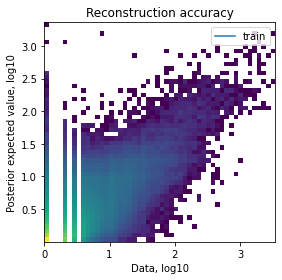

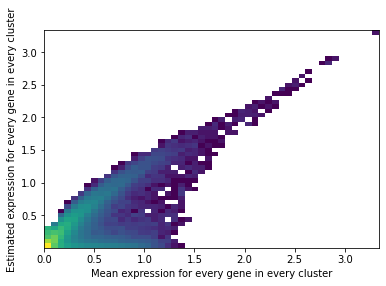

CPU times: user 1h 22min 56s, sys: 43min 5s, total: 2h 6min 1s
Wall time: 1h 28min 49s


In [7]:
%%time

from cell2location.utils.filtering import filter_genes
from cell2location.models import RegressionModel

for reg in ['LA']:
    print(f'####### {reg} #######')
    
    # subset adata
    adata_sub = adata_ref[adata_ref.obs['region']==reg].copy()
    
    # remove cell_states, which have less than 5 cells
    counts = adata_sub.obs[celltype_key].value_counts()
    adata_sub = adata_sub[adata_sub.obs[celltype_key].isin(list(counts.keys()[counts>=5]))]
    
    # add cells from other regions for low number (lower than 100) cell types
    counts = adata_sub.obs[celltype_key].value_counts()
    low_n_celltypes = list(counts.keys()[counts<100])
    ## add data of "other" regions & low_n_celltypes
    adata_toadd = adata_ref[(adata_ref.obs['region']!=reg)&(adata_ref.obs['cell_state'].isin(low_n_celltypes))]
    adata_sub = adata_sub.concatenate(adata_toadd,
                                     batch_key=None,
                                      index_unique=None)
    post_counts = adata_sub.obs[celltype_key].value_counts()
    
    # remove cell_states, which have only 2 cells or less
    # adata_sub = adata_sub[adata_sub.obs[celltype_key].isin(list(counts.keys()[post_counts>2]))]
    
    # downsize
    adata_sub = sctk.subsample(adata_sub, fraction=1, groupby=celltype_key, min_n=0, max_n=2000)
    
    # show pre add-sabsample and post
    post_counts = adata_sub.obs[celltype_key].value_counts()
    print(pd.DataFrame({'pre':counts,
                 'post_add-subsample':post_counts}))
    
    # before we estimate the reference cell type signature we recommend to perform very permissive genes selection
    # in this 2D histogram orange rectangle lays over excluded genes.
    # In this case, the downloaded dataset was already filtered using this method,
    # hence no density under the orange rectangle
    selected = filter_genes(adata_sub, cell_count_cutoff=5, cell_percentage_cutoff2=0.03, nonz_mean_cutoff=1.12)
    # filter the object
    adata_sub = adata_sub[:, selected].copy()
    
    # prepare anndata for the regression model
    adata_sub=adata_sub.copy()
    scvi.data.setup_anndata(adata=adata_sub, 
                            # 10X reaction / sample / batch
                            batch_key='batch_key', 
                            # cell type, covariate used for constructing signatures
                            labels_key=celltype_key, 
                            # multiplicative technical effects (platform, 3' vs 5', donor effect)
                            # categorical_covariate_keys=['Method']
                           )
    scvi.data.view_anndata_setup(adata_sub)
    
    # create and train the regression model
    mod = RegressionModel(adata_sub) 

    # Use all data for training (validation not implemented yet, train_size=1)
    mod.train(max_epochs=1000, batch_size=2500, train_size=1, lr=0.002, use_gpu=True)

    # plot ELBO loss history during training, removing first 20 epochs from the plot
    mod.plot_history(20)
    
    # In this section, we export the estimated cell abundance (summary of the posterior distribution).
    adata_sub = mod.export_posterior(
        adata_sub, sample_kwargs={'num_samples': 1000, 'batch_size': 2500, 'use_gpu': True}
    )

    # Save model
    mod.save(f"{ref_run_name}/{reg}", overwrite=True)

    # Save anndata object with results
    # adata_file = f"{ref_run_name}/{reg}/sc.h5ad"
    adata_sub.write(f"{ref_run_name}/{reg}/sc.h5ad")
    
    mod.plot_QC()
    
    # export estimated expression in each cluster
    if 'means_per_cluster_mu_fg' in adata_sub.varm.keys():
        inf_aver = adata_sub.varm['means_per_cluster_mu_fg'][[f'means_per_cluster_mu_fg_{i}' 
                                        for i in adata_sub.uns['mod']['factor_names']]].copy()
    else:
        inf_aver = adata_sub.var[[f'means_per_cluster_mu_fg_{i}' 
                                        for i in adata_sub.uns['mod']['factor_names']]].copy()
    inf_aver.columns = adata_sub.uns['mod']['factor_names']
    inf_aver.iloc[0:5, 0:5]
    
    # save inf_aver
    inf_aver.to_csv(f"{ref_run_name}/{reg}/inf_aver.csv")
                    
    del adata_sub, mod, inf_aver, adata_toadd, counts, post_counts

## Rerunning for AVN with updated cell states (27Jun2022)

####### AVN #######
                   pre  post_add-subsample
AVN_P_cell         154                 154
AVN_bundle_cell     42                  42
Adip1              135                 135
Adip2               39                1416
B                   23                1082
CD14+Mo             21                2000
CD16+Mo            114                 114
CD4+T_act           40                1758
CD4+T_naive         56                2000
CD8+T_cytox          9                1322
CD8+T_em            24                1375
CD8+T_trans         25                2000
DC                  20                 874
EC10_CMC-like       84                2000
EC1_cap            458                 458
EC2_cap            166                 166
EC3_cap             93                2000
EC4_immune          39                2000
EC5_art            562                 562
EC6_ven            395                 395
EC7_atria           27                2000
EC8_ln              51            

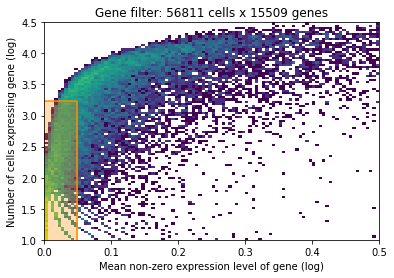

INFO     Using batches from adata.obs["batch_key"]                                           
INFO     Using labels from adata.obs["cell_state"]                                           
INFO     Using data from adata.X                                                             


/lustre/scratch117/cellgen/team205/kk18/miniconda3/envs/cell2loc_env/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function setup_anndata is deprecated; Please use the model-specific setup_anndata methods instead. The global method will be removed in version 0.15.0.


INFO     Successfully registered anndata object containing 56811 cells, 15509 vars, 27       
         batches, 52 labels, and 0 proteins. Also registered 0 extra categorical covariates  
         and 0 extra continuous covariates.                                                  
INFO     Please do not further modify adata until model is trained.                          


/lustre/scratch117/cellgen/team205/kk18/miniconda3/envs/cell2loc_env/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function view_anndata_setup is deprecated; This method will be removed in 0.15.0. Please avoid building any new dependencies on it.


Anndata setup with scvi-tools version 0.14.4.

              Data Summary              
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━┓
┃             Data             ┃ Count ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━┩
│            Cells             │ 56811 │
│             Vars             │ 15509 │
│            Labels            │  52   │
│           Batches            │  27   │
│           Proteins           │   0   │
│ Extra Categorical Covariates │   0   │
│ Extra Continuous Covariates  │   0   │
└──────────────────────────────┴───────┘

             SCVI Data Registry              
┏━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃     Data      ┃    scvi-tools Location    ┃
┡━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       X       │          adata.X          │
│ batch_indices │ adata.obs['_scvi_batch']  │
│    labels     │ adata.obs['_scvi_labels'] │
└───────────────┴───────────────────────────┘

                          Label Categories                          
┏━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃     Source Location     ┃    Categories    ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['cell_state'] │    AVN_P_cell    │          0          │
│                         │ AVN_bundle_cell  │          1          │
│                         │      Adip1       │          2          │
│                         │      Adip2       │          3          │
│                         │        B         │          4          │
│                         │     CD14+Mo      │          5          │
│                         │     CD16+Mo      │          6          │
│                         │    CD4+T_act     │          7          │
│                         │   CD4+T_naive    │          8          │
│                         │   CD8+T_cytox    │          9          │
│                         │     CD8+T_em     │         10          │
│                         │   CD8+T_trans    │         11          │
│                         │        DC        │         12          │
│                         │  EC10_CMC-like   │         13          │
│                         │     EC1_cap      │         14          │
│                         │     EC2_cap      │         15          │
│                         │     EC3_cap      │         16          │
│                         │    EC4_immune    │         17          │
│                         │     EC5_art      │         18          │
│                         │     EC6_ven      │         19          │
│                         │    EC7_atria     │         20          │
│                         │      EC8_ln      │         21          │
│                         │       FB1        │         22          │
│                         │       FB2        │         23          │
│                         │       FB3        │         24          │
│                         │       FB4        │         25          │
│                         │       FB5        │         26          │
│                         │       FB6        │         27          │
│                         │  LYVE1+IGF1+MP   │         28          │
│                         │ LYVE1+MP_cycling │         29          │
│                         │  LYVE1+TIMD4+MP  │         30          │
│                         │    MAIT-like     │         31          │
│                         │       Mast       │         32          │
│                         │       MoMP       │         33          │
│                         │       NC1        │         34          │
│                         │       NC2        │         35          │
│                         │    NK_CD16hi     │         36          │
│                         │    NK_CD56hi     │         37          │
│                         │     PC1_vent     │         38          │
│                         │    PC2_atria     │         39          │
│                         │     PC3_str      │         40          │
│                         │   PC4_CMC-like   │         41          │
│                         │    SMC1_basic    │         42          │
│                         │     SMC2_art     │         43          │
│                         │       aCM1       │         44          │
│                         │       aCM2       │         45          │
│                         │       aCM3       │         46          │
│                         │       aCM4       │         47          │
│                         │       vCM1       │         48          │
│                         │       vCM2       │         49          │
│                         │       vCM3       │         50          │
│                         │       vCM4       │         51          │
└─────────────────────────┴──────────────────┴─────────────────────┘

                            Batch Categories                             
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃    Source Location     ┃       Categories       ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['batch_key'] │ A61_Nuclei_Multiome-v1 │          0          │
│                        │ AH1_Nuclei_Multiome-v1 │          1          │
│                        │   D11_Cell_3prime-v3   │          2          │
│                        │  D11_Nuclei_3prime-v3  │          3          │
│                        │   D1_Cell_3prime-v2    │          4          │
│                        │  D1_Nuclei_3prime-v2   │          5          │
│                        │  D2_Nuclei_3prime-v2   │          6          │
│                        │   D3_Cell_3prime-v2    │          7          │
│                        │  D3_Nuclei_3prime-v2   │          8          │
│                        │ D3_Nuclei_Multiome-v1  │          9          │
│                        │   D4_Cell_3prime-v2    │         10          │
│                        │  D4_Nuclei_3prime-v2   │         11          │
│                        │   D5_Cell_3prime-v2    │         12          │
│                        │  D5_Nuclei_3prime-v2   │         13          │
│                        │   D6_Cell_3prime-v2    │         14          │
│                        │   D6_Cell_3prime-v3    │         15          │
│                        │  D6_Nuclei_3prime-v2   │         16          │
│                        │   D7_Cell_3prime-v2    │         17          │
│                        │  D7_Nuclei_3prime-v2   │         18          │
│                        │ D7_Nuclei_Multiome-v1  │         19          │
│                        │ D8_Nuclei_Multiome-v1  │         20          │
│                        │  H2_Nuclei_3prime-v3   │         21          │
│                        │  H3_Nuclei_3prime-v3   │         22          │
│                        │  H4_Nuclei_3prime-v3   │         23          │
│                        │  H5_Nuclei_3prime-v3   │         24          │
│                        │  H6_Nuclei_3prime-v3   │         25          │
│                        │  H7_Nuclei_3prime-v3   │         26          │
└────────────────────────┴────────────────────────┴─────────────────────┘

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
/lustre/scratch117/cellgen/team205/kk18/miniconda3/envs/cell2loc_env/lib/python3.9/site-packages/pytorch_lightning/trainer/configuration_validator.py:99: UserWarning: you passed in a val_dataloader but have no validation_step. Skipping val loop
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Sampling global variables, sample: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 999/999 [00:17<00:00, 55.87it/s]


/lustre/scratch117/cellgen/team205/kk18/miniconda3/envs/cell2loc_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
... storing 'sangerID' as categorical
/lustre/scratch117/cellgen/team205/kk18/miniconda3/envs/cell2loc_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
... storing 'combinedID' as categorical
/lustre/scratch117/cellgen/team205/kk18/miniconda3/envs/cell2loc_env/lib/python3.9/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version.

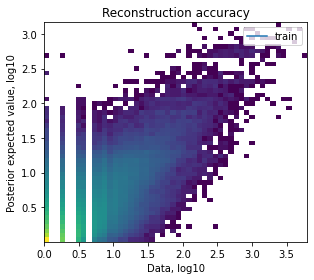

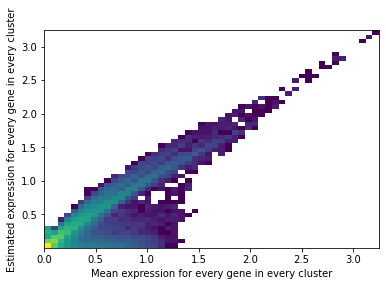

CPU times: user 1h 44min 55s, sys: 1h 2min 55s, total: 2h 47min 50s
Wall time: 2h 5min 53s


In [7]:
%%time

from cell2location.utils.filtering import filter_genes
from cell2location.models import RegressionModel

for reg in ['AVN']:
    print(f'####### {reg} #######')
    
    # subset adata
    adata_sub = adata_ref[adata_ref.obs['region']==reg].copy()
    
    # remove cell_states, which have less than 5 cells
    counts = adata_sub.obs[celltype_key].value_counts()
    adata_sub = adata_sub[adata_sub.obs[celltype_key].isin(list(counts.keys()[counts>=5]))]
    
    # add cells from other regions for low number (lower than 100) cell types
    counts = adata_sub.obs[celltype_key].value_counts()
    low_n_celltypes = list(counts.keys()[counts<100])
    ## add data of "other" regions & low_n_celltypes
    adata_toadd = adata_ref[(adata_ref.obs['region']!=reg)&(adata_ref.obs['cell_state'].isin(low_n_celltypes))]
    adata_sub = adata_sub.concatenate(adata_toadd,
                                     batch_key=None,
                                      index_unique=None)
    post_counts = adata_sub.obs[celltype_key].value_counts()
    
    # remove cell_states, which have only 2 cells or less
    # adata_sub = adata_sub[adata_sub.obs[celltype_key].isin(list(counts.keys()[post_counts>2]))]
    
    # downsize
    adata_sub = sctk.subsample(adata_sub, fraction=1, groupby=celltype_key, min_n=0, max_n=2000)
    
    # show pre add-sabsample and post
    post_counts = adata_sub.obs[celltype_key].value_counts()
    print(pd.DataFrame({'pre':counts,
                 'post_add-subsample':post_counts}))
    
    # before we estimate the reference cell type signature we recommend to perform very permissive genes selection
    # in this 2D histogram orange rectangle lays over excluded genes.
    # In this case, the downloaded dataset was already filtered using this method,
    # hence no density under the orange rectangle
    selected = filter_genes(adata_sub, cell_count_cutoff=5, cell_percentage_cutoff2=0.03, nonz_mean_cutoff=1.12)
    # filter the object
    adata_sub = adata_sub[:, selected].copy()
    
    # prepare anndata for the regression model
    adata_sub=adata_sub.copy()
    scvi.data.setup_anndata(adata=adata_sub, 
                            # 10X reaction / sample / batch
                            batch_key='batch_key', 
                            # cell type, covariate used for constructing signatures
                            labels_key=celltype_key, 
                            # multiplicative technical effects (platform, 3' vs 5', donor effect)
                            # categorical_covariate_keys=['Method']
                           )
    scvi.data.view_anndata_setup(adata_sub)
    
    # create and train the regression model
    mod = RegressionModel(adata_sub) 

    # Use all data for training (validation not implemented yet, train_size=1)
    mod.train(max_epochs=1000, batch_size=2500, train_size=1, lr=0.002, use_gpu=True)

    # plot ELBO loss history during training, removing first 20 epochs from the plot
    mod.plot_history(20)
    
    # In this section, we export the estimated cell abundance (summary of the posterior distribution).
    adata_sub = mod.export_posterior(
        adata_sub, sample_kwargs={'num_samples': 1000, 'batch_size': 2500, 'use_gpu': True}
    )

    # Save model
    mod.save(f"{ref_run_name}/{reg}", overwrite=True)

    # Save anndata object with results
    # adata_file = f"{ref_run_name}/{reg}/sc.h5ad"
    adata_sub.write(f"{ref_run_name}/{reg}/sc.h5ad")
    
    mod.plot_QC()
    
    # export estimated expression in each cluster
    if 'means_per_cluster_mu_fg' in adata_sub.varm.keys():
        inf_aver = adata_sub.varm['means_per_cluster_mu_fg'][[f'means_per_cluster_mu_fg_{i}' 
                                        for i in adata_sub.uns['mod']['factor_names']]].copy()
    else:
        inf_aver = adata_sub.var[[f'means_per_cluster_mu_fg_{i}' 
                                        for i in adata_sub.uns['mod']['factor_names']]].copy()
    inf_aver.columns = adata_sub.uns['mod']['factor_names']
    inf_aver.iloc[0:5, 0:5]
    
    # save inf_aver
    inf_aver.to_csv(f"{ref_run_name}/{reg}/inf_aver.csv")
                    
    del adata_sub, mod, inf_aver, adata_toadd, counts, post_counts